In [1]:
import sys
sys.path.append('../..')
from dataloader import *
from model import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd

2024-01-25 11:09:08.310230: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 11:09:08.311289: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 11:09:08.335979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 11:09:08.769363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.manual_seed(42)

## Load data

In [3]:
ETTh1_data = pd.read_csv('../../data/ETTh1.csv', header=None).to_numpy()

In [4]:
ETTh1_data.shape

(17420, 7)

In [5]:
batch_size = 32
n_train = 8545
n_eval = 2881
n_test = 2881
train_loader, eval_loader, test_loader = get_loaders(ETTh1_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Train

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#writer = SummaryWriter()

cpu


In [7]:
N = 7 
T = 96 
D = 512 
S = 96 
hidden_dim = 64
num_blocks = 1 

itransformer = iTransformer(N, T, D, S, hidden_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-4, weight_decay=1e-5) 


In [8]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device)

---- epoch :  0
loss train : 0.3866188003207153
loss eval : 0.6982508203522726
---- epoch :  1
loss train : 0.3642140323261045
loss eval : 0.687190248884938
---- epoch :  2
loss train : 0.35394399784645947
loss eval : 0.6904389760033651
---- epoch :  3
loss train : 0.3445678342063472
loss eval : 0.6909486265345053
---- epoch :  4
loss train : 0.33705362790035753
loss eval : 0.682635404846885
---- epoch :  5
loss train : 0.3300247939690104
loss eval : 0.6924525448544459
---- epoch :  6
loss train : 0.3232984602451324
loss eval : 0.6970257857306437
---- epoch :  7
loss train : 0.3160702303895411
loss eval : 0.7360037517818537
Early stopping after 7 epochs without improvement.


## Test

In [9]:
loss_test, loss_mae, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)
print("MAE : ", loss_mae)

MSE :  0.3909434638917446
MAE :  0.4084228686988354


Affichage pour une modalité sur toute la durée de la prédiction

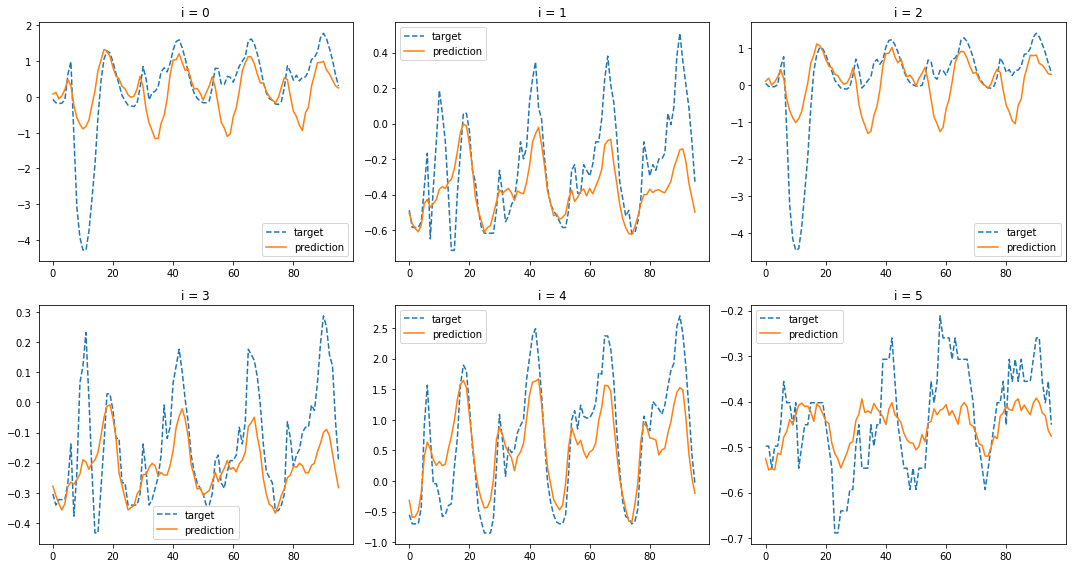

In [10]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    current_i = i - 1
    
    plt.plot(target[0, :, current_i].to("cpu"), "--", label="target")
    plt.plot(yhat[0, :, current_i].to("cpu"), label="prediction")
    
    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

Affichage de toutes les modalités à un instant t

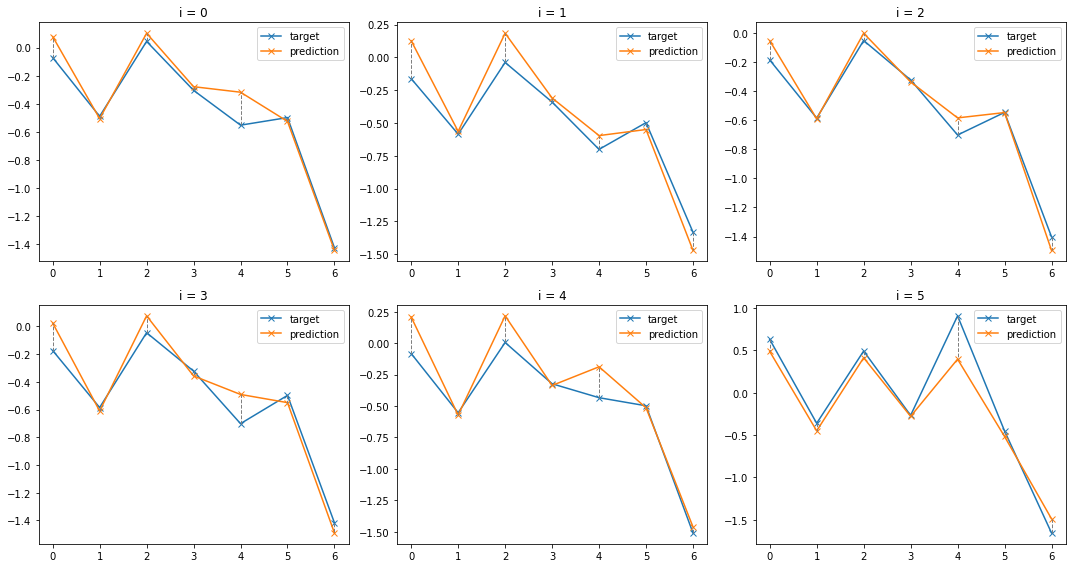

In [11]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    
    current_i = i - 1
    
    plt.plot(np.arange(len(target[0, current_i, :7])), target[0, current_i, :20].cpu(), marker='x', label="target")
    plt.plot(np.arange(len(target[0, current_i, :7])), yhat[0, current_i, :20].cpu(), marker='x', label="prediction")

    for j in range(len(target[0, 0, :7])):
        plt.plot([j, j], [target[0, current_i, j].to("cpu"), yhat[0, current_i, j].cpu()], color='gray', linestyle='--', linewidth=1)

    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

## Expérience saliency 

In [27]:
LOOK_FORWARD = 96
BATCH_SIZE = 32
PATH = "../../resultats/saliency"

def perturbation_data(x, num_window, mod, mode="zero", size_window=1):
    x_noisy = x.clone()
    if mode =="zero":
        x_noisy[num_window * size_window: (num_window+1) * size_window, mod] = 0
    elif mode == "mean_mod":
        x_noisy[num_window * size_window: (num_window+1) * size_window, mod] = x_noisy[:, mod].mean(dim=0)
    elif mode =="mean_time":
        x_noisy[num_window * size_window: (num_window+1) * size_window, mod] =x_noisy[num_window * size_window: (num_window+1) * size_window, :].mean(dim=1)
    return x_noisy

def score(target, yhat, yhat_noisy):
    criterion = torch.nn.MSELoss()
    loss = criterion(target, yhat)
    loss_noisy = criterion(target, yhat_noisy)

    diff_loss = loss - loss_noisy
    return diff_loss


def saliency_map(dataset, itransformer, x, target, N, mode="zero", size_window=1, idx_ex=0):
    saliency_map = np.zeros((N, LOOK_FORWARD//size_window))
    for mod in range(N):
        for num_window in range(LOOK_FORWARD//size_window): 
            x_noisy = perturbation_data(x, num_window, mod, mode=mode, size_window=1)
            yhat_noisy = itransformer(x_noisy.reshape((1, 96, N)))[0]
            yhat = itransformer(x.reshape((1, 96, N)))[0]
            saliency_map[mod, num_window] = score(target, yhat, yhat_noisy)

    
    plt.imshow(saliency_map, cmap='viridis', aspect='auto')
    plt.title('Saliency Map')
    plt.xlabel('Time')
    plt.ylabel('Modality')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"{PATH}/{dataset}/saliency_{mode}_{idx_ex}.png")
    plt.show()
    print(f"saved {PATH}/{dataset}/saliency_{mode}_{idx_ex}.png")
    
    
    best_mod = np.argmax(np.sum(saliency_map, axis=1))
    variate = x[:, best_mod]
    
    plt.figure()
    plt.plot(variate.to("cpu"), "--", label=f"Modality {best_mod}")
    plt.title(f"Lookback modality {best_mod}")
    plt.legend()
    plt.savefig(f"{PATH}/{dataset}/modality_{mode}_{idx_ex}_{best_mod}.png")
    print(f"saved {PATH}/{dataset}/modality_{mode}_{idx_ex}_{best_mod}.png")
    
    
    best_t = np.argmax(saliency_map[best_mod])
    #x_noisy = perturbation_data(x, best_t, mod, mode=mode, size_window=1)
    x_noisy[:, best_mod] = 0

    if mode =="zero":
        x_noisy[:, best_mod] = 0
    elif mode == "mean_mod":
        for t in range(96):
            x_noisy[t * size_window: (t+1) * t, best_mod] = x_noisy[:, best_mod].mean(dim=0)
    elif mode =="mean_time":
        for t in range(96):
            x_noisy[t * size_window: (t+1) * t, best_mod] =x_noisy[t * size_window: (t+1) * size_window, :].mean(dim=1)


    yhat_noisy = itransformer(x_noisy.reshape((1, 96, N)))
    yhat = itransformer(x.reshape((1, 96, N)))

    yhat_noisy = yhat_noisy[0,:,best_mod]
    yhat = yhat[0,:,best_mod]
    target = target[:,best_mod]

    plt.figure()
    plt.plot(target.to("cpu"), "--", label=f"target")

    plt.plot(yhat.detach().numpy(), label=f"prediction")
    plt.plot(yhat_noisy.detach().numpy(), label=f"prediction (perturbation)")
    plt.title(f"Prediction modality {best_mod}")
    plt.legend(loc='upper right')
    plt.savefig(f"{PATH}/{dataset}/yhat_{mode}_{idx_ex}_{best_mod}.png")
    print(f"saved {PATH}/{dataset}/yhat_{mode}_{idx_ex}_{best_mod}.png")
    plt.show()

=========== NB 0 ===============
------- 0 :


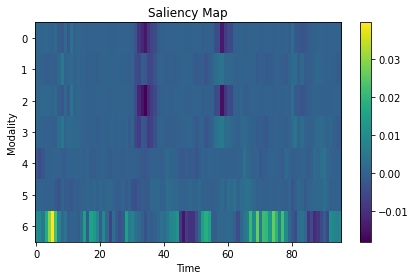

saved ../../resultats/saliency/ETTh1/saliency_mean_time_0.png
saved ../../resultats/saliency/ETTh1/modality_mean_time_0_6.png
saved ../../resultats/saliency/ETTh1/yhat_mean_time_0_6.png


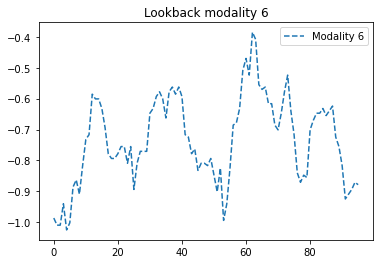

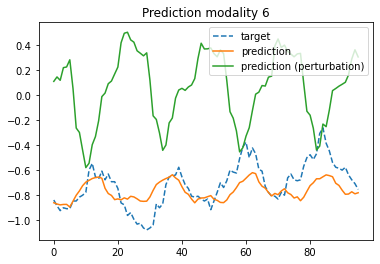

In [33]:
nb = 0
NB=0
for x_batch, target_batch in test_loader:
        if nb == NB : 
                print(f"=========== NB {nb} ===============")
                for idx_ex in range(x_batch.shape[0]): 
                        print(f"------- {idx_ex} :")
                        x = x_batch[idx_ex].float().to(device)
                        target = target_batch[idx_ex].float().to(device)
                        saliency_map("ETTh1", itransformer, x, target, N, mode="mean_time", size_window=1, idx_ex=idx_ex)
                        
                        break
                break
        nb+=1
